<a href="https://www.kaggle.com/code/mohamedbakrey/colon-cancer-classification-using-deep-learning?scriptVersionId=94507103" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import itertools
import cv2
import os
import time

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB7  as PretrainedModel, preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from glob import glob

# Loading the data

In [2]:
# Copying the folders into a single folder
!mkdir ./LungColon

print('Copying files...')
!cp -R ../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/* ./LungColon
!cp -R ../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/* ./LungColon
print('All files copied successfully!')

mkdir: cannot create directory ‘./LungColon’: File exists
Copying files...
All files copied successfully!


In [10]:
folders = glob('./LungColon' + '/*')

In [12]:
print('New Paths: ', folders)

IMAGE_FILES = glob('./LungColon' + '/*/*.jpeg')
print('Images Count: ', len(IMAGE_FILES))

New Paths:  ['./LungColon/colon_aca', './LungColon/colon_n', './LungColon/lung_n', './LungColon/lung_scc', './LungColon/lung_aca']
Images Count:  25000


# Show some of data

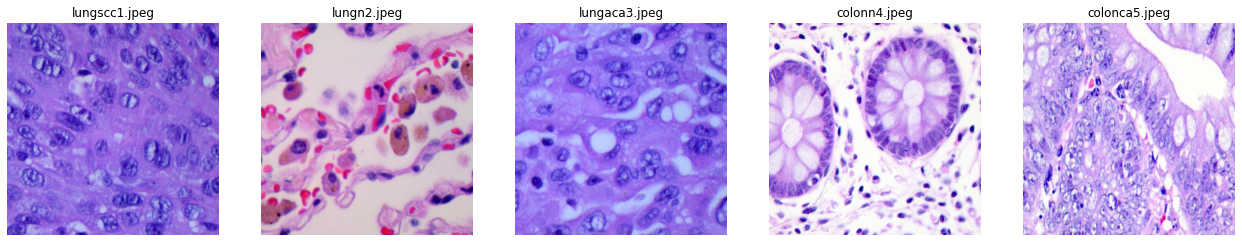

In [4]:
SAMPLES = ['./LungColon/lung_scc/lungscc1.jpeg', './LungColon/lung_n/lungn2.jpeg', 
           './LungColon/lung_aca/lungaca3.jpeg', './LungColon/colon_n/colonn4.jpeg', 
           './LungColon/colon_aca/colonca5.jpeg']

plt.figure(figsize=(22, 8)) 
global c
c = 0

for i in SAMPLES:
    plt.subplot(1, 5, c + 1)
    c += 1
    t = i.split('/')
    plt.title(t[3])
    plt.imshow(image.load_img(i))
    plt.axis('off')
plt.show()

### Trainig Data

In [5]:
data_dir = './LungColon'

# 80-20 Split
data = ImageDataGenerator(validation_split = 0.2)

BATCH_SIZE = 128

# 224 x 224 -- The minimum for EfficientNetB7, you can go as high as 600 x 600
X = Y = 224

train_ds = data.flow_from_directory(data_dir,
                                    class_mode = "categorical",
                                    target_size = (X, Y),
                                    color_mode="rgb",
                                    batch_size = BATCH_SIZE, 
                                    shuffle = False,
                                    subset='training',
                                    seed = 42)

Found 20000 images belonging to 5 classes.


### Validation Data

In [6]:

validation = data.flow_from_directory(data_dir,
                                      class_mode = "categorical",
                                      target_size = (X, Y),
                                      color_mode="rgb",
                                      batch_size = BATCH_SIZE, 
                                      shuffle = False,
                                      subset='validation',
                                      seed = 42)

Found 5000 images belonging to 5 classes.


# Build The Model

In [11]:
ptm = PretrainedModel(
    input_shape=(X, Y, 3),
    weights='imagenet',
    include_top=False)

ptm.trainable = False

K = len(folders)

x = GlobalAveragePooling2D()(ptm.output)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)

y = Dense(K, activation='softmax')(x)

model = Model(inputs=ptm.input, outputs=y)

In [13]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)



In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
______________________________________________________________________________________________

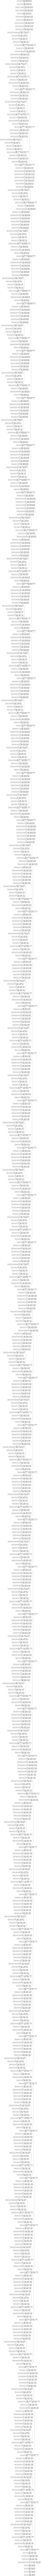

In [15]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='NN-mnist.png', show_shapes=True)

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    train_ds,
    validation_data=validation,
    epochs=50,
    callbacks=[early_stopping])

2022-05-01 15:29:34.392278: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-05-01 15:29:53.830458: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


157/157 [==============================] - 319s 2s/step - loss: 0.6641 - accuracy: 0.7566 - val_loss: 0.2334 - val_accuracy: 0.9186
Epoch 2/50
157/157 [==============================] - 288s 2s/step - loss: 0.2434 - accuracy: 0.9100 - val_loss: 0.1504 - val_accuracy: 0.9444
Epoch 3/50
157/157 [==============================] - 287s 2s/step - loss: 0.1701 - accuracy: 0.9367 - val_loss: 0.0987 - val_accuracy: 0.9664
Epoch 4/50
157/157 [==============================] - 286s 2s/step - loss: 0.1485 - accuracy: 0.9427 - val_loss: 0.1270 - val_accuracy: 0.9520
Epoch 5/50
157/157 [==============================] - 285s 2s/step - loss: 0.1295 - accuracy: 0.9508 - val_loss: 0.0793 - val_accuracy: 0.9714
Epoch 6/50
157/157 [==============================] - 285s 2s/step - loss: 0.0910 - accuracy: 0.9667 - val_loss: 0.0727 - val_accuracy: 0.9718
Epoch 7/50
157/157 [==============================] - 286s 2s/step - loss: 0.1121 - accuracy: 0.9574 - val_loss: 0.0635 - val_accuracy: 0.9776
Epoch 8/50

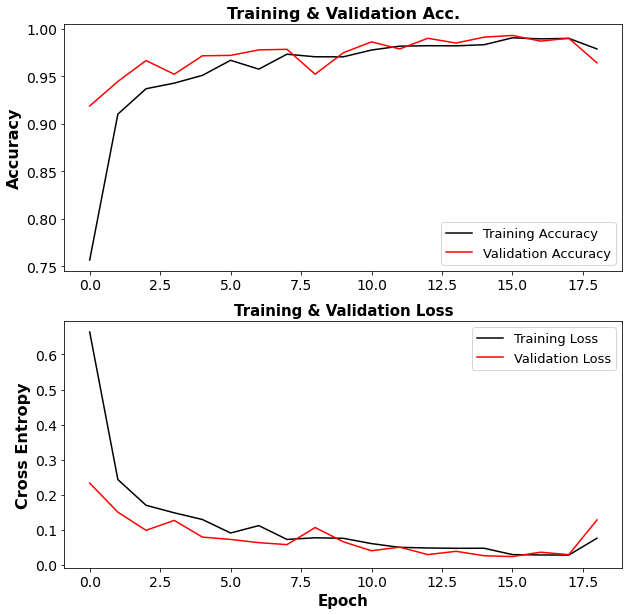

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy', color='black')
plt.plot(val_acc, label='Validation Accuracy', color='red')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('Training & Validation Acc.', fontsize=16, weight='bold')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='black')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.show()


### classification_report

In [22]:
from sklearn.metrics import classification_report

Y_pred = model.predict(validation)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(validation.classes, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1000
           1       0.99      1.00      1.00      1000
           2       0.99      0.84      0.91      1000
           3       0.89      1.00      0.94      1000
           4       0.96      0.99      0.98      1000

    accuracy                           0.96      5000
   macro avg       0.97      0.96      0.96      5000
weighted avg       0.97      0.96      0.96      5000



## Compute confusion matrix

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')



Normalized confusion matrix


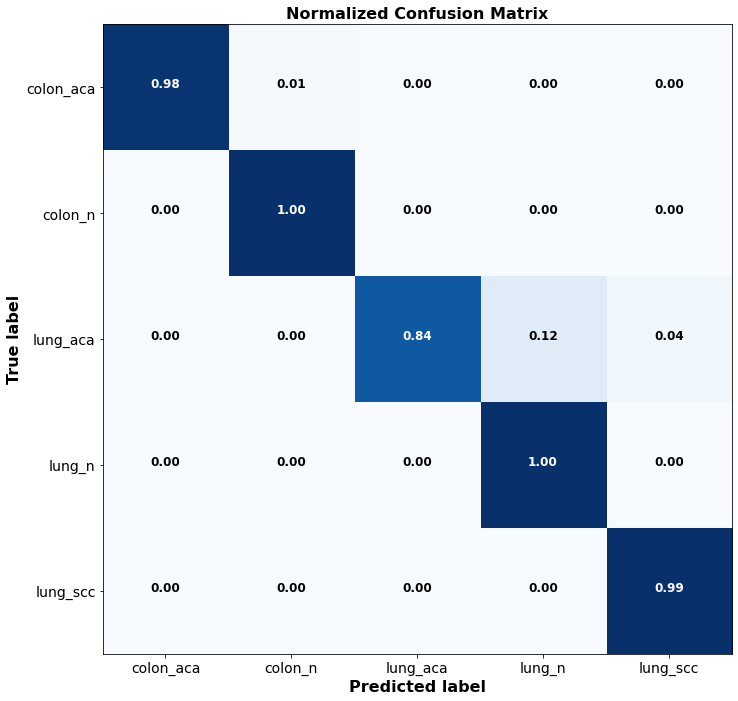

In [26]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(validation.classes, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc'],normalize=True,
                      title='Normalized Confusion Matrix')
plt.show()